In [202]:
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_context("talk")
import numpy as np
import os
import importlib
from pyagn import sed
importlib.reload(sed)
from glob import glob
from matplotlib import cm
from plot_utils.paper import set_size
import plot_utils
from plot_utils import paper 
importlib.reload(plot_utils.paper)
from qwind import plotting
importlib.reload(plotting)
import matplotlib as mpl
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}

mpl.rcParams.update(nice_fonts)
from qwind import wind
from qwind.radiation import simple_sed, qsosed
importlib.reload(wind)
importlib.reload(simple_sed)
importlib.reload(qsosed)
from qwind import aux_numba
importlib.reload(aux_numba)
from qwind.radiation import simple_sed
importlib.reload(simple_sed)
import pandas as pd

# SED plot

In [21]:
disc_colors = [
    '#ffc857',
    "#e9724C",
    '#c5283d',
    '#aa1155',
    '#880044'
]

In [22]:
bh = sed.SED(M = 1e8, mdot = 0.5)
distance = 1e26

In [4]:
warm_flux = bh.warm_flux(distance)
corona_flux = bh.corona_flux(distance)
total_flux = bh.total_flux(distance)

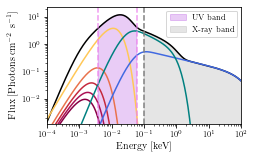

In [33]:
fig, ax = plt.subplots(1,1, figsize = paper.set_size(subplot=[1,1]))
distance = 1e26
r_range = [50, 250, 450, 650, 850]
dr = 20
colormap = cm.viridis(np.linspace(0,1,5))
disk_fluxes = []
energy_range = bh.ENERGY_RANGE_KEV
disk_line_list = []
xray_mask = energy_range > 0.1
total_line, = ax.loglog(energy_range, total_flux, color = 'black', label = 'Total' )
uv = ax.fill_between(x = energy_range[bh.UV_MASK], y1 = 0 , y2 = total_flux[bh.UV_MASK], color = 'darkviolet', alpha = 0.2, label = "UV band")
xray = ax.fill_between(x = energy_range[xray_mask], y1 = 0 , y2 = total_flux[xray_mask], color = 'grey', alpha = 0.2, label = "X-ray band")

for i, r in enumerate(r_range):
    disk_flux = np.pi * bh.disk_spectral_radiance_kev(energy_range, r)
    disk_lumin = disk_flux * 4 * np.pi * bh.Rg**2 * dr #* ((r+dr/2.)**2 - (r-dr/2.)**2)
    disk_flux = disk_lumin / (4 * np.pi * distance**2 )
    disk_line, = ax.loglog(energy_range, disk_flux, label = "%d"%r, color = disc_colors[i])
    disk_line_list.append(disk_line)
    #if i == 0:
    #    ax.fill_between(x = energy_range, y1 =0 , y2 = disk_flux, color = 'grey', alpha = 0.15)
    #ax.fill_between(x = energy_range[bh.UV_MASK], y1 =0 , y2 = disk_flux[bh.UV_MASK], color = 'white')
    #ax.fill_between(x = energy_range[bh.UV_MASK], y1 =0 , y2 = disk_flux[bh.UV_MASK], color = disc_colors[i], alpha = 0.3)
    disk_fluxes.append(disk_flux)
    
#first_legend = ax.legend(handles=disk_line_list, loc=1, title = "Disc Radius [Rg]")
#first_legend.get_title().set_fontsize('18') #legend 'Title' fontsize
#ax.add_artist(first_legend)
corona_line, = ax.loglog(energy_range, corona_flux, color = 'royalblue', label = 'Corona')
#ax.fill_between(x = energy_range[bh.UV_MASK], y1 = 0 , y2 = corona_flux[bh.UV_MASK], color = 'royalblue', alpha = 0.3)

warm_line, = ax.loglog(energy_range, warm_flux, color = 'teal', label = 'Warm region')
#ax.fill_between(x = energy_range[bh.UV_MASK], y1 = 0 , y2 = warm_flux[bh.UV_MASK], color = 'teal', alpha = 0.3)



ax.axvline(bh.ENERGY_UV_LOW_CUT_KEV, color = 'violet', linestyle = '--', alpha = 0.8)
split = ax.axvline(bh.ENERGY_UV_HIGH_CUT_KEV, color = 'violet', linestyle = '--', label = 'UV band', alpha = 0.8)

split2 = ax.axvline(0.1, color = 'grey', linestyle = '--', label = "X-ray band")
#= ax.axvline(100, color = 'grey', linestyle = '--', label = 'X-ray band')


ax.legend(handles = [uv, xray], loc="upper right")
ax.set_ylim(np.max(total_flux) / 10000, np.max(total_flux) * 2)
ax.set_xlim(1e-4,1e2)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux [Photons cm$^{-2}$ s$^{-1}$] ")
plt.savefig("sed_uv_intersection.pdf", format='pdf', bbox_inches="tight")

# Radial UV fraction plot

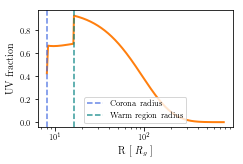

In [33]:
fig, ax = plt.subplots(figsize=paper.set_size())
color  = plt.get_cmap("plasma")(np.linspace(0,1,3))[1]
fractions_uv, _, _, component_fractions = bh.compute_uv_fractions(1e26, include_corona = True, return_all = True)
fraction_r_range = np.linspace(bh.corona_radius, bh.gravity_radius, len(fractions_uv) )
ax.semilogx(fraction_r_range, fractions_uv, color = 'C1', linewidth = 2)
ax.axvline(bh.corona_radius, color = 'royalblue', linestyle = "--", label = 'Corona radius', alpha = 0.8)
ax.axvline(bh.warm_radius, color = 'teal', linestyle = "--", label = 'Warm region radius', alpha = 0.8)
ax.set_ylabel(r"UV fraction")
ax.set_xlabel(r"R [ $R_g$ ]")
ax.legend(loc = "lower center")
#plt.tight_layout()
plt.savefig("radial_uv_fractions.pdf", format='pdf', bbox_inches="tight")

# Total UV fraction plot

In [31]:
M_range = np.geomspace(1e7,1e10, 11)
mdot_range = np.geomspace(0.05, 1, 10)

fractions = []
for M in M_range:
    for mdot in mdot_range:
        bh = sed.SED(M=M, mdot = mdot)
        fractions.append([bh.uv_fraction, bh.xray_fraction])
        

fractions = np.array(fractions)

fractions = fractions.reshape(11,10,2)

fraction_uv = fractions[...,0]
fraction_xray = fractions[...,1]

/cosma7/data/dp004/dc-quer1/pyagn/pyagn/sed.py:310: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  radial_integral = 2 * np.pi**2 * self.Rg**2 * integrate.quad( lambda r: r * self.disk_spectral_radiance(energy, r), self.warm_radius, self.gravity_radius)[0]


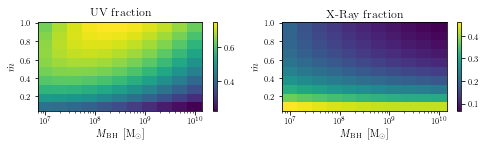

In [32]:
fig, ax = plt.subplots(1,2, figsize=paper.set_size('mnras_double', subplot=[1,2]))
#uv = ax[0].pcolormesh(np.log10(M_range), np.log10(mdot_range), fraction_uv)
uv = plotting.pcolormesh_sensible(M_range, mdot_range, fraction_uv, ax[0], cmap = "viridis", logx=True, logy=False, logNorm = False) 
plt.colorbar(uv, ax = ax[0])
ax[0].set_title("UV fraction")

#xr = ax[1].pcolormesh(np.log10(M_range), np.log10(mdot_range), fraction_xray)
xr = plotting.pcolormesh_sensible(M_range, mdot_range, fraction_xray, ax[1], cmap = "viridis", logx=True, logy=False, logNorm=False) 
plt.colorbar(xr, ax = ax[1])
ax[1].set_title("X-Ray fraction")

for axis in ax:
    axis.set_xlabel(r"$\;M_\mathrm{BH} \;$ [M$_\odot$]")
    axis.set_ylabel(r"$ \dot m$")
#    labels = [item.get_text().replace("−", "-") for item in ax[0].get_yticklabels()]
    
    #labels = [10**float(label) for label in labels]
    #ax[0].set_xticklabels(labels)

plt.tight_layout()
#labels = [float(item.get_text().replace("−", "-")) for item in ax[0].get_yticklabels()]
#labels_new = ["%.2f"%(10**label) for label in labels]
#a = ax[0].set_yticklabels(labels_new)

#labels = [float(item.get_text().replace("−", "-")) for item in ax[1].get_yticklabels()]
#labels_new = ["%.2f"%(10**label) for label in labels]
#b = ax[1].set_yticklabels(labels_new)
#plt.savefig("../../UV_XR_fractions.png", dpi=200, bbox_to_inches="tight")
plt.savefig("uv_xray_fractions.pdf", format='pdf', bbox_inches="tight")

# Qwind grid plots

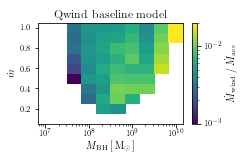

In [128]:
importlib.reload(plotting)
fig, ax = plt.subplots(1,1,figsize = set_size(subplot = [1,1]))
BASE_FOLDER = "../batch_scripts/baseline/rho_02.00_vel_01.00"
ax = plotting.plot_mloss_grid(BASE_FOLDER ,
                              title = r"Qwind baseline model",
                              ax = ax,
                              vmin = 0.001,
                              vmax = 0.02,
                              logy=False,
                              cmap="viridis"
                              )

plt.savefig("grid_baseline.pdf", format='pdf', bbox_inches="tight")

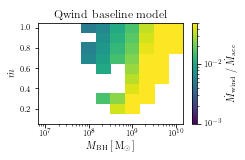

In [248]:
importlib.reload(plotting)
fig, ax = plt.subplots(1,1,figsize = set_size(subplot = [1,1]))
BASE_FOLDER = "../batch_scripts/super_grid_rin50/rho_10.00_vel_05.00"
ax = plotting.plot_mloss_grid(BASE_FOLDER ,
                              title = r"Qwind baseline model",
                              ax = ax,
                              vmin = 0.001,
                              vmax = 0.05,
                              logy=False,
                              cmap = "viridis",
                              
                              )

#plt.savefig("grid_baseline.pdf", format='pdf', bbox_inches="tight")

M_1.0e+09_mdot_0.10


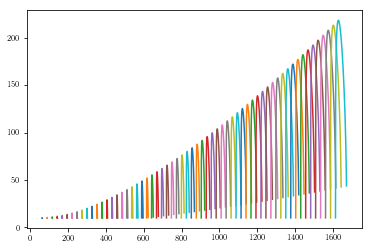

M_1.0e+09_mdot_0.20


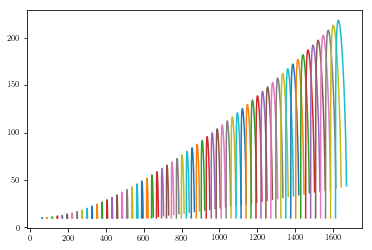

M_1.0e+09_mdot_0.30


KeyboardInterrupt: 

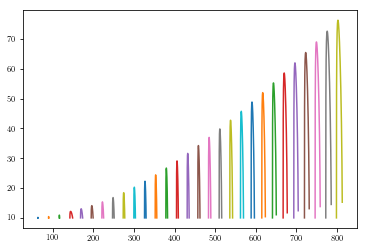

In [231]:
BASE_FOLDER = "../batch_scripts/super_grid_rin50/rho_01.00_vel_10.00/"
for sample in np.sort(glob(os.path.join(BASE_FOLDER, "M_1.0e+09*"))):
    print(os.path.split(sample)[-1])
    lines = np.sort(glob(os.path.join(sample, "line_*")))
    for line in lines:
        line_data = pd.read_csv(line)
        plt.plot(line_data.R, line_data.Z)
    #plt.xlim(0,1500)
    #plt.ylim(0,50)
    plt.show()
    

# Force multiplier

In [14]:
interp = wind.Qwind(radiation_mode = "SimpleSED", modes=["interp_fm"])
no_interp = wind.Qwind(radiation_mode = "SimpleSED")

r_in: 200.000000 
 r_out: 1600.000000
r_in: 200.000000 
 r_out: 1600.000000


In [15]:
t_range = [1e-2, 1e-4, 1e-6]
xi_range = np.geomspace(1e-5, 1e5)

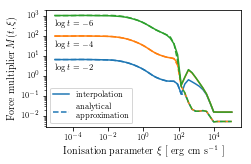

In [18]:
fig, ax = plt.subplots(figsize=set_size())
cmap = plt.get_cmap("plasma")(np.linspace(0,1,len(t_range)))
line_list = []
for i,t in enumerate(t_range):
    fm_interp = [interp.radiation.force_multiplier(t,xi) for xi in xi_range]
    fm_no_interp = [no_interp.radiation.force_multiplier(t,xi) for xi in xi_range]
    line_interp, = ax.loglog(xi_range, fm_interp, color = 'C%d'%i)
    line_no_interp, = ax.loglog(xi_range, fm_no_interp, color = "C%d"%i, linestyle="--")
    line_list.append(line_interp)
    line_list.append(line_no_interp)
    ax.text(xi_range[0], fm_interp[0]*0.30, r"$\log t=%.0d$"%np.log10(t), fontsize=8)
ax.legend(handles=line_list, labels=["interpolation", "analytical \n approximation"])#, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r"Ionisation parameter $\xi$ [ erg cm s$^{-1}$ ]")
ax.set_ylabel(r"Force multiplier $M(t,\xi)$")
plt.savefig("force_multiplier.pdf", format='pdf', bbox_inches="tight")

# wind example

In [ ]:
example = wind.Qwind(M=2e8, mdot=0.5, radiation_mode="SimpleSED", nr=20, n_cpus=1, modes = ["interp_fm"])
lines = example.start_lines(niter = 50000, rho = 2e8)

r_in: 200.000000 
 r_out: 1600.000000
Starting line iteration
Line 1 of 20


Failed wind! 


Line 2 of 20


Failed wind! 


Line 3 of 20


escape velocity reached.
out of grid 

Line 4 of 20


escape velocity reached.
out of grid 

Line 5 of 20


Failed wind! 

Line 6 of 20


Failed wind! 

Line 7 of 20


Failed wind! 

Line 8 of 20


Failed wind! 

Line 9 of 20


Failed wind! 

Line 10 of 20


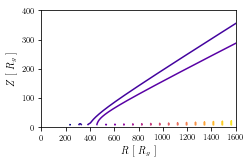

In [30]:
fig, ax = plt.subplots(figsize=set_size())
cmap = plt.get_cmap("plasma")(np.linspace(0,1,len(lines)))
for i, line in enumerate(lines):
    ax.plot(line.r_hist, line.z_hist, color = cmap[i])
ax.set_xlim(0,1600)
ax.set_ylim(0,400)
ax.set_xlabel(r"$R$ [ $R_g$ ]")
ax.set_ylabel(r"$Z$ [ $R_g$ ]")
plt.savefig("wind_example.pdf", format='pdf', bbox_inches="tight")

# Super Grid Plot

In [218]:
def get_index(array, value):
    index = np.argmin(np.abs(array - value))
    return index

In [249]:
# read data
folders = glob("../batch_scripts/super_grid_rin50/*")
data = {
    'rho' : [],
    'vel' : [],
    'data' : [],
}
for folder in folders:
    _, folder_name = os.path.split(folder)
    rho = float(folder_name.split("_")[1]) * 1e8
    vel = float(folder_name.split("_")[-1]) * 1e7
    data['rho'].append(rho)
    data['vel'].append(vel)
    data_pd = plotting.read_data(folder)
    data['data'].append(data_pd)   

KeyError: 'M'

In [ ]:
rho_values = np.sort(np.unique(data['rho']))
vel_values = np.sort(np.unique(data['vel']))[::-1]

In [ ]:
fig, ax = plt.subplots(3,6,figsize=set_size('mnras_double'), sharex = True, sharey = True)
for k in range(0,18):
    rho = data['rho'][k]
    vel = data['vel'][k]
    j = get_index(rho_values, rho)
    i = get_index(vel_values, vel)
    data_grid = data['data'][k]
    M_range = data_grid.M.unique()
    mdot_range = data_grid.mdot.unique()
    mloss = np.array(data_grid.mloss_norm).reshape(len(M_range), len(mdot_range))
    cmap = plotting.pcolormesh_sensible(M_range, mdot_range, mloss, ax[i][j], logx=True, logy=False,
                                        cmap = "viridis", vmin = 0.001, vmax = 0.1)
    if j == 0:
        ax[i,j].set_ylabel(r"$v_0 = %.1f \; v_7$"%(vel/1e7), labelpad = 25)
    if i == 2:
        ax[i,j].set_xlabel(r"$n_0 = 10^{%d} \; n_8$"%(np.log10(rho/1e8)), labelpad = 25)
        
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
fig.text(0.5, 0.03, r"M [ $M_\mathrm{BH}$ ]", ha='center')
fig.text(0.05, 0.5, r"$\dot m$", ha='center', rotation = 90)

cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label(r"Normalised mass loss rate $\dot M_\mathrm{wind} / \dot M_\mathrm{acc}$", labelpad = 15, rotation=-90)
fig.savefig("super_grid_rin50.pdf", format="pdf", bbox_inches="tight")

# integral convergence

In [30]:
quad = wind.Qwind(radiation_mode="SimpleSED", modes=['gravityonly'])
qline = quad.line(z_0 = 1)
qline.iterate(niter=5000)

r_in: 200.000000 
 r_out: 1600.000000


/cosma7/data/dp004/dc-quer1/qwind/qwind/aux_numba.py:234: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  r_max, args=(r, z), points=[r])[0]
/cosma7/data/dp004/dc-quer1/qwind/qwind/aux_numba.py:236: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  r_max, args=(r, z), points=[r])[0]


Failed wind! 



In [31]:
old = wind.Qwind(radiation_mode="SimpleSED", modes=['old_integral', 'gravityonly'])
oline = old.line(z_0 = 1)
oline.iterate(niter=5000)

r_in: 200.000000 
 r_out: 1600.000000


Failed wind! 



In [41]:
dblquad = wind.Qwind(radiation_mode="SimpleSED", modes=['dbl_quad', 'gravityonly'])
dqline = dblquad.line(z_0 = 1)
dqline.iterate(niter=5000)

r_in: 200.000000 
 r_out: 1600.000000


Failed wind! 



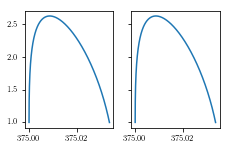

In [140]:
fig, ax = plt.subplots(1,2, figsize=set_size(), sharex = True, sharey=True)
ax[0].plot(qline.r_hist, qline.z_hist)
ax[1].plot(oline.r_hist, oline.z_hist)

Text(0.5, -0.05, 'Iteration number')

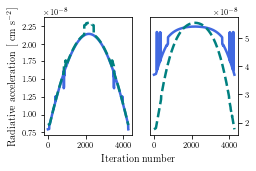

In [142]:
fig, ax = plt.subplots(1,2, figsize=set_size(), sharex = True)
ax[0].plot(np.array(qline.radiation.int_hist)[:,0], color = 'royalblue', linewidth = 2.5)
ax[0].plot(np.array(dqline.radiation.int_hist)[:,0], color = 'teal', linewidth = 2.5, linestyle='--')
ax[1].plot(np.array(qline.radiation.int_hist)[:,1], color = 'royalblue', linewidth = 2.5)
ax[1].plot(np.array(dqline.radiation.int_hist)[:,1], color = 'teal', linewidth = 2.5, linestyle='--')
ax[1].yaxis.tick_right()
ax[0].set_ylabel(r"Radiative acceleration [ cm s$^{-2}$]")
fig.text(0.5, -0.05, r"Iteration number", ha='center')

In [180]:
r_range = np.geomspace(10,1000,51)
z_range = np.geomspace(5, 500,50)

In [181]:
old_grid = []
q_grid = []
dq_grid = []
dq_error_grid = []
for r in r_range:
    for z in z_range:
        #old_int = np.array(aux_numba.qwind_integration(r,z))
        #old_grid.append(old_int)
        #q_int = np.array(aux_numba.integration_quad_nointerp(r,z, dblquad.r_min, dblquad.r_max ))
        #q_grid.append(q_int)
        dq_int = np.array(aux_numba.qwind_integration_dblquad(r, z, dblquad.r_min, dblquad.r_max))
        dq_int_val = dq_int[[0,1]]
        dq_error = np.array(dq_int[[2,3]]) / dq_int_val
        dq_grid.append(dq_int_val)
        dq_error_grid.append(dq_error)
#old_grid = np.array(old_grid).reshape(51,50,2)
#q_grid = np.array(q_grid).reshape(51,50,2)
dq_grid = np.array(dq_grid).reshape(51,50,2)
dq_error_grid = np.array(dq_error_grid).reshape(51,50,2)





# dblquad values

In [198]:
importlib.reload(plotting)

<module 'qwind.plotting' from '/cosma7/data/dp004/dc-quer1/qwind/qwind/plotting.py'>

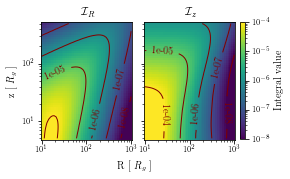

In [199]:
fig, ax = plt.subplots(1,2, figsize=set_size(), sharex=True, sharey=True)
plt.subplots_adjust(wspace = 0.13)
cmap1 = plotting.pcolormesh_sensible(r_range,
                                     z_range,
                                     dq_grid[...,0],
                                     ax[0],
                                     cmap = "viridis",
                                     vmin = 1e-8,
                                     vmax = 1e-4,
                                     contour_plot = True,
                                     n_contours = np.geomspace(1e-8, 1e-4,5),
                                    )
cmap2 = plotting.pcolormesh_sensible(r_range,
                                     z_range,
                                     dq_grid[...,1],
                                     ax[1],
                                     cmap = "viridis",
                                     vmin = 1e-8,
                                     vmax = 1e-4,
                                     contour_plot = True,
                                     n_contours = np.geomspace(1e-8, 1e-4,5),
                                    )
ax[0].set_title(r"$\mathcal I_R$")
ax[1].set_title(r"$\mathcal I_z$")
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
fig.colorbar(cmap1, cax=cbar_ax, label=r"Integral value")
ax[0].set_ylabel(r"z [ $R_g$ ]")
fig.text(0.5, -0.07, r"R [ $R_g$ ]", ha='center')
fig.savefig("dblquad_values.pdf", bbox_inches="tight")

In [ ]:
dblquad.radiation.force_radiation(150, 50, 0, 0, 0)

In [ ]:
dblquad.radiation.force_radiation(150, 10, 0, 0, 0)

# dblquad errors

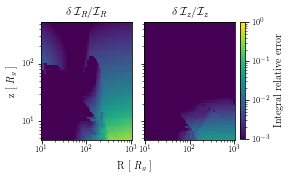

In [201]:
fig, ax = plt.subplots(1,2, figsize=set_size(), sharex=True, sharey=True)
plt.subplots_adjust(wspace = 0.13)
cmap1 = plotting.pcolormesh_sensible(r_range,
                                     z_range,
                                     dq_error_grid[...,0],
                                     ax[0],
                                     cmap = "viridis",
                                     vmin = 1e-3,
                                     vmax = 1,
                                     contour_plot = False,
                                     n_contours = np.geomspace(1e-3, 1,4),
                                    )
cmap2 = plotting.pcolormesh_sensible(r_range,
                                     z_range,
                                     dq_error_grid[...,1],
                                     ax[1],
                                     cmap = "viridis",
                                     vmin = 1e-3,
                                     vmax = 1,
                                     contour_plot = False,
                                     n_contours = np.geomspace(1e-3, 1,4),
                                    )
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
ax[0].set_title(r"$\delta \, \mathcal I_R / \mathcal I_R$")
ax[1].set_title(r"$\delta \, \mathcal I_z / \mathcal I_z$")
fig.colorbar(cmap1, cax=cbar_ax, label=r"Integral relative error")
ax[0].set_ylabel(r"z [ $R_g$ ]")
fig.text(0.5, -0.07, r"R [ $R_g$ ]", ha='center')
fig.savefig("dblquad_errors.pdf", bbox_inches="tight")

In [234]:
np.linspace(5e6,5e7,3)

array([ 5000000., 27500000., 50000000.])